
### PGE 383 Exercise: Bayesian Linear Regression for Subsurface Modeling in Python 

Here's a simple workflow, demonstration of Bayesian linear regression for subsurface modeling workflows. This should help you get started with building subsurface models with data analytics and machine learning. Here's some basic details about Bayesian linear regression. 


#### Bayesian Updating

The prediction for Bayesian linear regression is distributed:

\begin{equation}
y \sim N(\beta^{T}X, \sigma^{2} I)
\end{equation}

We estimate the model parameter distributions through Bayesian updating for infering the model parameters from a prior and likelihood from training data.

\begin{equation}
p(\beta | y, X) = \frac{p(y,X| \beta) p(\beta)}{p(y,X)}
\end{equation}

In general for continuous features, we must use a sampling method, such as Markov chain Monte Carlo to sample the posterior.


#### Workflow Goals

Learn the basics of isotonic regression in Python for analysis, modeling and prediction of porosity from density. This includes:

* Basic Python workflows and data preparation

* Training / fitting a ridge regression model

* Checking the model and learning about the impact of hyperparameters

#### Objective 

Content to support the PGE 383: Subsurface Machine Learning class.  

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

There are examples below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Import Required Packages

Let's import the GeostatsPy package.

In [2]:
import os                                                   # to set current working directory 
import numpy as np                                          # arrays and matrix math
import scipy.stats as st                                    # statistical methods
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # for plotting
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.metrics import explained_variance_score
import seaborn as sns                                       # advanced plotting
import sys                                                  # interactive with terminal window to install pymc3 package
seed = 73073

#### Loading Data

Let's load the provided dataset. 'GrainSize_por.csv' is available at https://github.com/GeostatsGuy/GeoDataSets. It is a comma delimited file with 20 grain size ($mm$) and porosity (as a percentage) measures from the subsurface. We load the data file with the pandas 'read_csv' function into a data frame we called 'df'.  We preview each with the head function from Pandas DataFrames.

In [5]:
#df = pd.read_csv("GrainSize_Por.csv")                    # read a .csv file in as a DataFrame
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/GrainSize_Por.csv")
df.head()

,Grainsize,Porosity
0,2.689284,5.400000
1,6.683638,10.647582
2,9.877106,7.926271
3,12.239344,11.278953
4,27.623312,10.508753


#### Visualize the Data

Looks like a reasonable dataset for a linear regression model. 

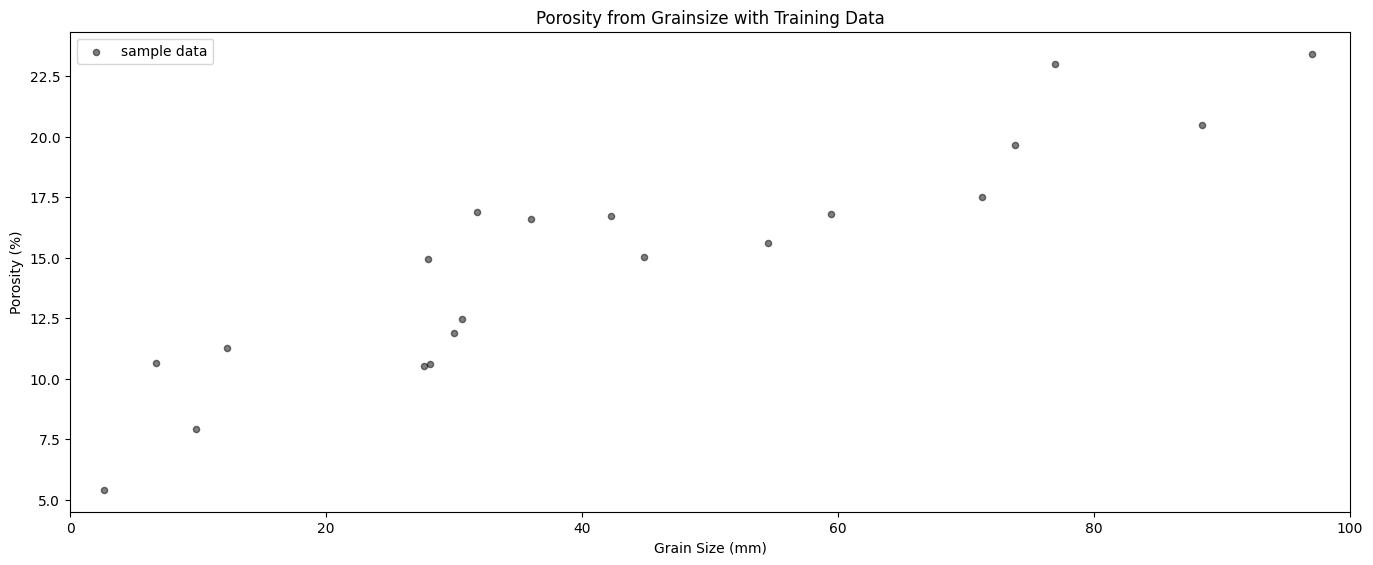

In [6]:
X_data = df.iloc[:,0]
y_data = df.iloc[:,1]
plt.subplot(111)
plt.scatter(X_data, y_data, color='black', s = 20, alpha = 0.5, label='sample data')
plt.title('Porosity from Grainsize with Training Data'); plt.xlabel('Grain Size (mm)'); plt.ylabel('Porosity (%)')
plt.xlim(0,100)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

#### Least Squares Linear Regression 

Let's calculate the ordinary least squares (OLS) linear regression model for comparison.

* for a non-informative prior our Bayesian linear regression model parameters will be centered on the OLS solution.

In [7]:
OLS_slope, OLS_intercept, r_value, p_value, std_err = st.linregress(X_data,y_data)

print('The model parameters are, slope (b1) = ' + str(round(OLS_slope,2)) + ', and the intercept (b0) = ' + str(round(OLS_intercept,2)))

The model parameters are, slope (b1) = 0.16, and the intercept (b0) = 8.12


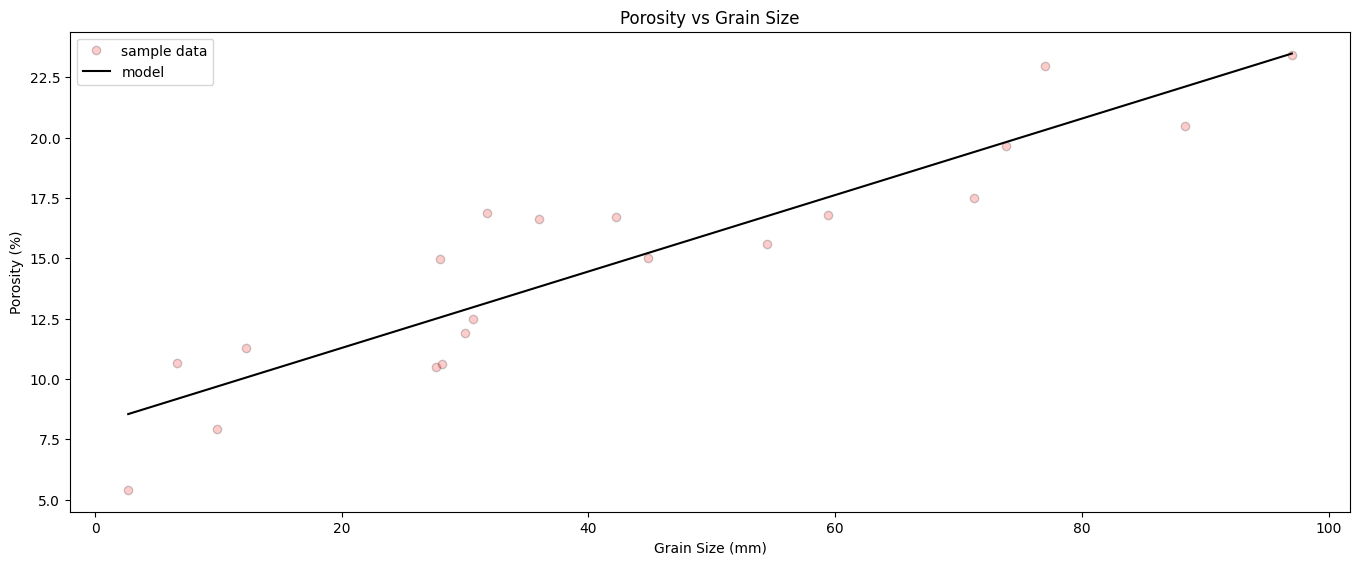

In [8]:
plt.subplot(111)
plt.plot(X_data, y_data, 'o', label='sample data', color = 'red', alpha = 0.2, markeredgecolor = 'black')
plt.plot(X_data, OLS_intercept + OLS_slope*X_data, label='model', color = 'black')
plt.title('Porosity vs Grain Size')
plt.xlabel('Grain Size (mm)')
plt.ylabel('Porosity (%)')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

The following code was based on the work of Will Koehrsen [blog post](https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7) and example workflow in [Jupyter Notebook](https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Demonstration.ipynb).


https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Demonstration.ipynb

#### Bayesian Linear Regression

In the following code we take advantage of the pymc3 package's API to build a very readible and compact model.

The parts include:

* specify the prior models for $\beta_0$, $\beta_1$ and $\sigma^2$.

* specify the model estimates

* define the distribution of the predictions and the observated predictor features

* specify the specific form for the MCMC steps

* conduct MCMC sampling

Note the default MCMC method in pymc3 is the Hamiltonian Monte Carlo (HMC).

* HMC reduces correlation between succesive samples by including proposals for moves to distant states, $L$
* No U-Turn Sampler (NUTS) is an extension of HMC that auotmatically tunes L to avoid oscillation 

In [9]:
with pm.Model() as linear_all_data:
    # prior distributions, Naive - set to Gaussian with very large variance
    intercept = pm.Normal('Intercept', mu = 0, sd = 10.0) # model B0 - Intercept Prior
    slope = pm.Normal('slope', mu = 0, sd = 10.0)         # model B1 - Slope Prior 
    sigma = pm.HalfNormal('sigma', sd = 10.0)             # homoscedastic error in standard deviation
    
    # specify the model, linear regression
    mean = intercept + slope * X_data                     # estimate of model
    
    # define the distribution of the predictions from the model and provide the sampled response features
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y_data.values[:]) # Observed values
    
    # specify the sampler
    step = pm.NUTS(target_accept = 0.95) # use the No-U-Turn Sampler (NUTS) for Markov Chains Monte Carlo MCMC, addaptive step size

    # Posterior distribution
    #linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = seed, return_inferencedata = True)
    linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = seed, 
                                      discard_tuned_samples = False,return_inferencedata=True)
 

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 5 seconds.


#### Summary Statistics for the Model Parameter Posterior Samples

It is useful to assess the mean, dispersion and credible intervals for the model parameters.

Some definitions to assist:

* *HDI* - highest density interval, all points have higher probability than points outside the interval
* *MCSE* - local Monte Carlo standard error 
* *ESS* - evolution of effective sample size, a measure of the sample size required to achive the same precision as random sampling. A measure of skewness of the distribution over time.

In [10]:
def trace_mean(x):
    return pd.Series(np.average(x, 0), name='mean')

def trace_sd(x):
    return pd.Series(np.std(x, 0), name='sd')

def trace_975(x):
    return pd.Series(np.percentile(x, 97.5), name='97.5')

def trace_025(x):
    return pd.Series(np.percentile(x, 2.5), name='2.5')

# Get the expectation / average for the model parameters from sampling the posterior distribution
bayes_exp_intercept = pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean]).iloc[0,0]
bayes_exp_slope = pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean]).iloc[1,0]

pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean, trace_sd, trace_025, trace_975])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,trace_mean,trace_sd,trace_025,trace_975
Intercept,8.115,0.943,6.240,9.820,0.052,0.037,322.0,260.0,1.00,8.115,0.943,6.261,9.982
slope,0.158,0.019,0.125,0.193,0.001,0.001,301.0,270.0,1.01,0.158,0.019,0.123,0.194
sigma,2.166,0.384,1.534,2.894,0.019,0.013,439.0,529.0,1.01,2.166,0.384,1.571,3.013


In [11]:
pm.stats.summary(linear_trace_all_data, stat_funcs = [trace_mean])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,trace_mean
Intercept,8.115,0.943,6.240,9.820,0.052,0.037,322.0,260.0,1.00,8.115
slope,0.158,0.019,0.125,0.193,0.001,0.001,301.0,270.0,1.01,0.158
sigma,2.166,0.384,1.534,2.894,0.019,0.013,439.0,529.0,1.01,2.166


#### Diagnostic Plots

For each of the model parameters, let's look at the results for the 4 Markov chains.

* distributions / PDFs based on kernel density estimates (KDE) from the 1000 MCMC states

* trace of the samples over each state to observe for burn-in, stuck in local minimums / sufficient variation 

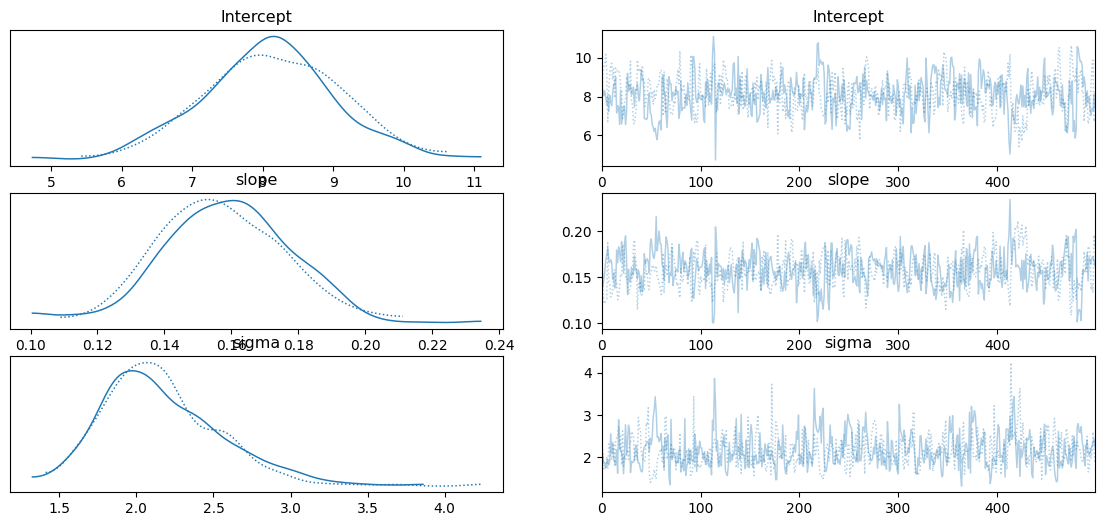

In [12]:
with linear_all_data:
    pm.plot_trace(linear_trace_all_data, figsize = (14,6))

#plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

#### Posterior Distributions

We can take our 1000 states from our 4 Markov chains as samples of the posterior distributions of our Bayesian linear regresion model parameters. 

* once again the distributions are represented as PDFs from kernel density estimation 

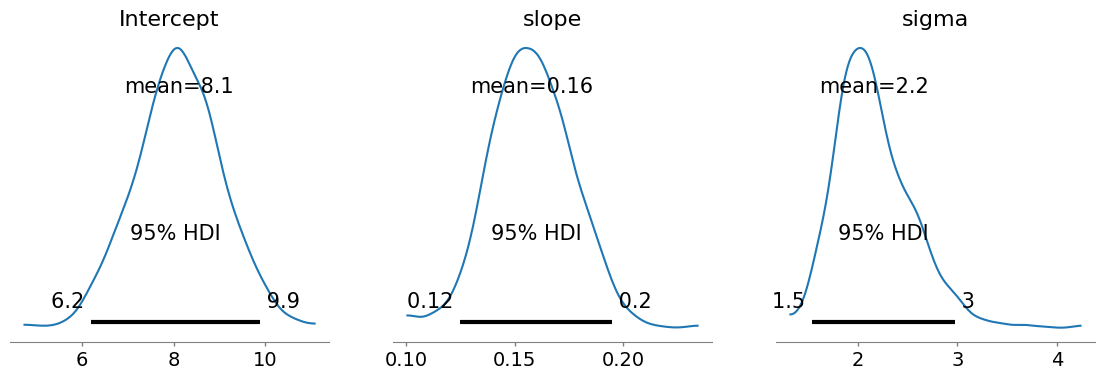

In [13]:
with linear_all_data:
    pm.plot_posterior(linear_trace_all_data,hdi_prob = 0.95, figsize = (14,4))
plt.show()

#### Visualize the Credible Intervals for the Model Parameters

We can visualize the credible intervals for all of the model parameters

* one for each Markov chain

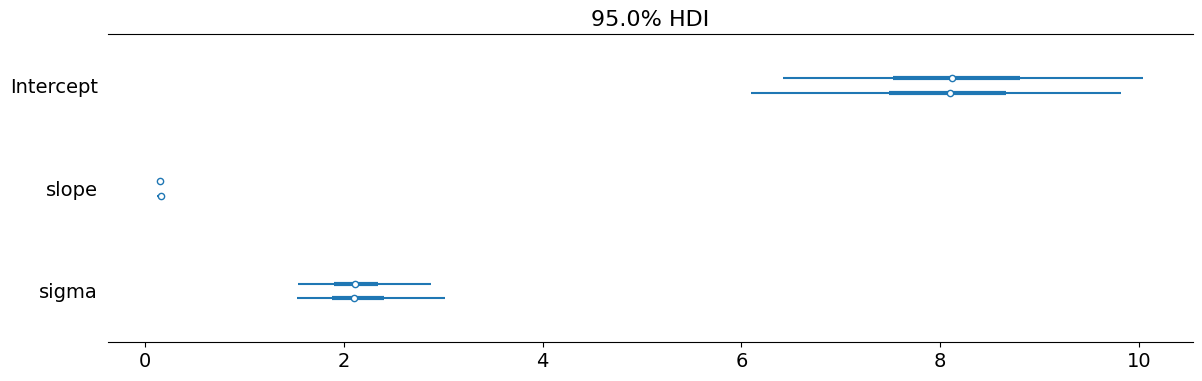

In [14]:
with linear_all_data:
    pm.plot_forest(linear_trace_all_data, hdi_prob = 0.95, figsize = (14,4))
plt.show()

#### Sampling the Bayesian Regression Model

We can sample from the resulting uncertainty distributions for the model parameters.

* we'll sample 1000 times and visualize the reuslting models


/home/kenny/.local/lib/python3.10/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


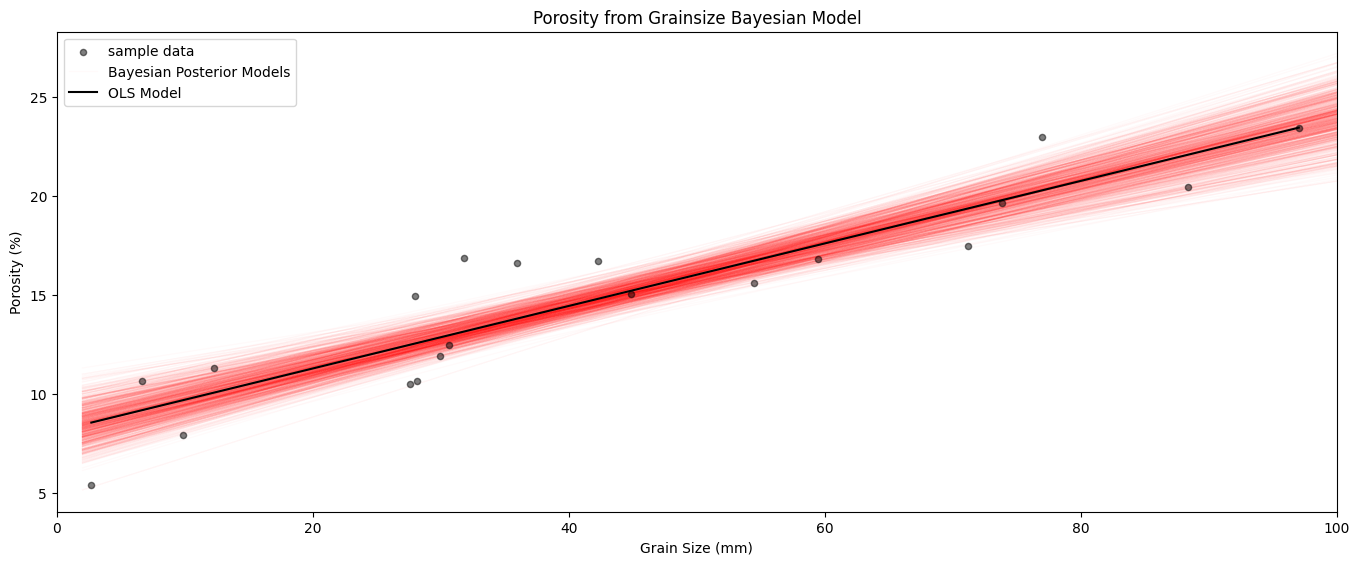

In [15]:
plt.subplot(111)
plt.scatter(X_data, y_data, color='black', s = 20, alpha = 0.5, label='sample data', zorder = 3)
pm.plot_posterior_predictive_glm(linear_trace_all_data, samples = 1000, eval=np.linspace(2, 100, 100), linewidth = 1, color = 'red', alpha = 0.02, label = 'Bayesian Posterior Models',lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x, zorder = 1)
plt.plot(X_data, bayes_exp_intercept + bayes_exp_slope*X_data, label='OLS Model', color = 'black', zorder= 2)
plt.title('Porosity from Grainsize Bayesian Model'); plt.xlabel('Grain Size (mm)'); plt.ylabel('Porosity (%)')
plt.xlim(0,100)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

#### Posterior Prediction 

Let's pick a specific grain size and apply the above 1000 samples of the model to sample the Bayes posterior prediction.

* note we would still need to add in the noise term, $\sigma$, to the model samples

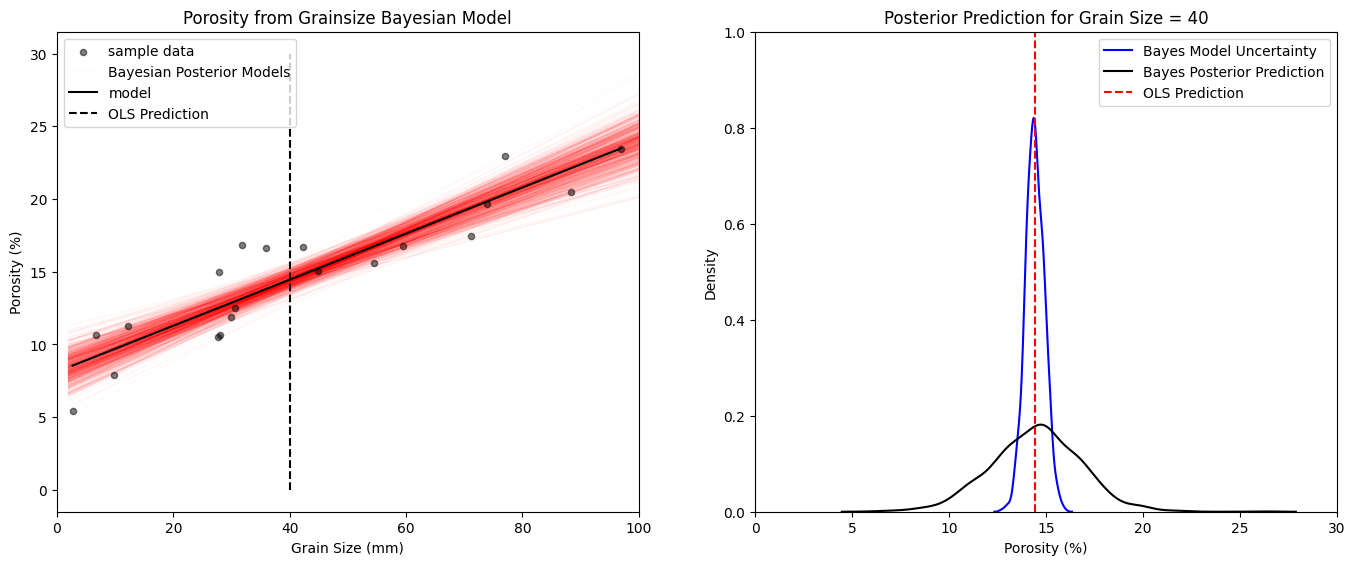

In [16]:
grain_size = 40
nruns = linear_trace_all_data.posterior['slope'].shape[0]
slopes = linear_trace_all_data.posterior['slope'].values
intercepts = linear_trace_all_data.posterior['Intercept'].values
sigmas = linear_trace_all_data.posterior['sigma'].values

plt.subplot(121)
plt.scatter(X_data, y_data, color='black', s = 20, alpha = 0.5, label='sample data', zorder = 3)
pm.plot_posterior_predictive_glm(linear_trace_all_data, samples = 1000, eval=np.linspace(2, 100, 100), linewidth = 1, color = 'red', alpha = 0.02, label = 'Bayesian Posterior Models',lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x, zorder = 1)

plt.plot(X_data, OLS_intercept + OLS_slope*X_data, label='model', color = 'black', zorder= 2)
plt.vlines(x = grain_size,ymin = 0, ymax = 30, label = 'OLS Prediction',colors = 'black', linestyles='--')
plt.title('Porosity from Grainsize Bayesian Model'); plt.xlabel('Grain Size (mm)'); plt.ylabel('Porosity (%)')
plt.xlim(0,100)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

plt.subplot(122)
model_uncert = intercepts + slopes * grain_size
sns.kdeplot(model_uncert.flatten(), label = 'Bayes Model Uncertainty', color = 'blue')
bayes_prediction = intercepts + slopes * grain_size + np.random.normal(loc=0,scale=sigmas,size=[nruns,500])
sns.kdeplot(bayes_prediction.flatten(), label = 'Bayes Posterior Prediction', color = 'black')
plt.vlines(x = OLS_intercept + OLS_slope * grain_size,ymin = 0, ymax = 2.5, label = 'OLS Prediction',colors = 'red', linestyles='--')
plt.xlim(0,30),plt.ylim(0,1.0)
plt.xlabel('Porosity (%)'), plt.ylabel('Density');
plt.title('Posterior Prediction for Grain Size = ' + str(grain_size));
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()